In [1]:
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


train_data = dset.FashionMNIST(
                root='./data',
                train=True,
                download=True,
                transform=transforms.ToTensor()
              )

test_data = dset.FashionMNIST(
                root = '/data',
                train = False,
                download = True,
                transform= transforms.ToTensor()
              )


100%|██████████| 26421880/26421880 [00:00<00:00, 63203248.16it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 91835966.29it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 9688755.54it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 1806129.40it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 26421880/26421880 [00:00<00:00, 52415642.47it/s]


Extracting /data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 5033130.69it/s]


Extracting /data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 17551637.34it/s]


Extracting /data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 25049045.23it/s]

Extracting /data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /data/FashionMNIST/raw



In [2]:
len(train_data), len(test_data)

(60000, 10000)

In [3]:
class_names = train_data.classes
class_names, len(train_data.classes)

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 10)

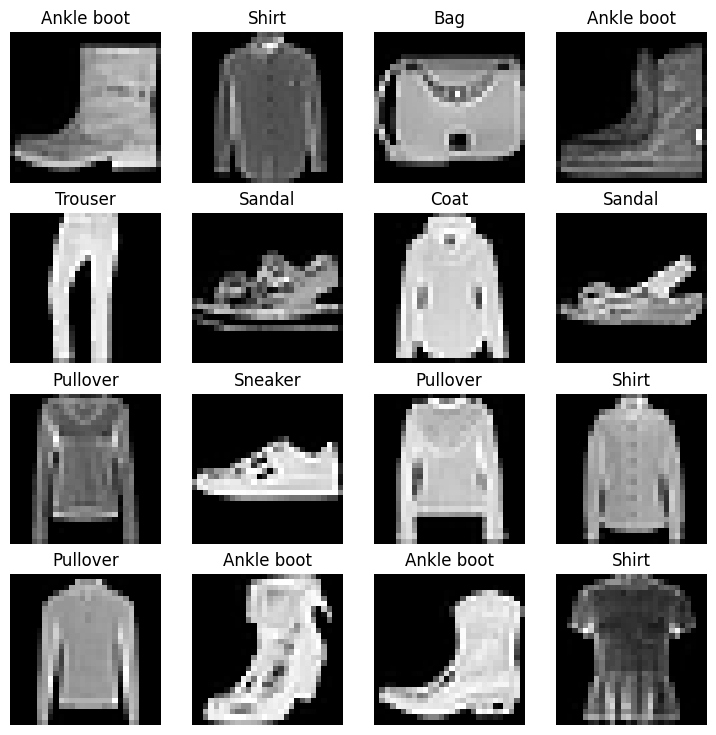

In [4]:
#Plot more images
torch.manual_seed(42)
figs = plt.figure(figsize=(9,9))
row, col = 4, 4

for i in range(1, row*col+1):
  randidx = torch.randint(0, len(train_data), size=[1]).item()
  image, label = train_data[randidx]
  figs.add_subplot(row,col,i)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis('off')

In [5]:
#Data Loader
from torch.utils.data import DataLoader
train_dload = DataLoader(train_data, batch_size=32, shuffle=True)
test_dload = DataLoader(test_data, batch_size=32, shuffle=False)

In [6]:
train_features_batch, train_labels_batch = next(iter(train_dload))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Text(0.5, 1.0, 'Shirt')

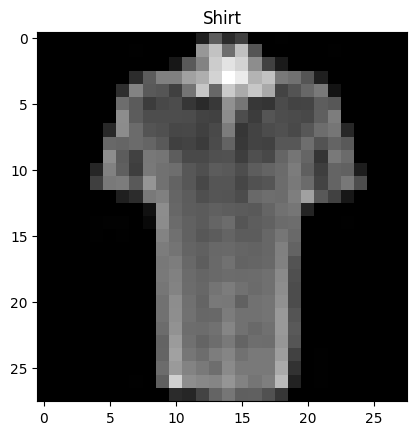

In [7]:
torch.manual_seed(42)
randidx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, lbl = train_features_batch[randidx], train_labels_batch[randidx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[lbl])

In [8]:
class FashionMNIST(nn.Module):
  def __init__(self, input_shape=int, hidden_units=int, output_shape=int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)

    )

  def forward(self, x):
    return self.layer_stack(x)

torch.manual_seed(42)
model_FMNIST = FashionMNIST(input_shape=28*28, hidden_units=10, output_shape=len(train_data.classes))

model_FMNIST


FashionMNIST(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [9]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [10]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model_FMNIST.parameters(), lr=0.1)

In [11]:
import tqdm
from tqdm.auto import tqdm
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [12]:
torch.manual_seed(42)
epochs = 3
train_time_start_cpu0 = timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch No:{epoch}")
  train_loss = 0
  train_acc = 0
  for batch,(X,y) in enumerate(train_dload):
    model_FMNIST.train()

    y_pred = model_FMNIST(X)
    loss = loss_fn(y_pred,y)
    train_loss +=loss.item()
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%400 ==0:
      print(f"looked at: {batch*len(X)}/{len(train_dload.dataset)}")

  train_loss /= len(train_dload)
  train_acc /= len(train_dload)
  print(f"Train Loss: {train_loss:.5f}")
  print(f"Train Accuracy: {train_acc:.5f}")


  test_loss, test_acc = 0, 0
  model_FMNIST.eval()

  with torch.inference_mode():
    for X,y in test_dload:
      test_pred = model_FMNIST(X)
      test_loss += loss_fn(test_pred, y).item() # Convert loss to a Python number
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

  test_loss /= len(test_dload)
  test_acc /= len(test_dload)
  print(f"Test Loss: {test_loss:.5f}")
  print(f"Test Accuracy: {test_acc:.5f}")
  print(f"Train Loss: {train_loss:.5f}")

time_end_cpu0 = timer()
print_train_time(start=train_time_start_cpu0, end=time_end_cpu0)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch No:0
looked at: 0/60000
looked at: 12800/60000
looked at: 25600/60000
looked at: 38400/60000
looked at: 51200/60000
Train Loss: 2.91053
Train Accuracy: 70.02333
Test Loss: 2.29266
Test Accuracy: 74.69050
Train Loss: 2.91053
Epoch No:1
looked at: 0/60000
looked at: 12800/60000
looked at: 25600/60000
looked at: 38400/60000
looked at: 51200/60000
Train Loss: 3.43212
Train Accuracy: 72.84000
Test Loss: 2.65037
Test Accuracy: 78.48442
Train Loss: 3.43212
Epoch No:2
looked at: 0/60000
looked at: 12800/60000
looked at: 25600/60000
looked at: 38400/60000
looked at: 51200/60000
Train Loss: 3.41116
Train Accuracy: 73.47667
Test Loss: 4.23463
Test Accuracy: 71.06629
Train Loss: 3.41116
Train time on None: 30.292 seconds


30.292465660000005

In [13]:
class FashionMNIST1(nn.Module):
  def __init__(self, input_shape=int, hidden_units=int, output_shape=int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_shape),
        nn.ReLU()

    )

  def forward(self, x):
    return self.layer_stack(x)

torch.manual_seed(42)
model_FMNIST1 = FashionMNIST1(input_shape=28*28, hidden_units=10, output_shape=len(train_data.classes))

model_FMNIST1


FashionMNIST1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [14]:
num_classes=len(train_data.classes)
num_classes

10

In [15]:
from helper_functions import accuracy_fn
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(params=model_FMNIST1.parameters(),
                            lr=0.1)

In [16]:
def train_step(data_load:torch.utils.data.DataLoader, model:nn.Module,loss_fn:nn.Module, optimizer:torch.optim, Accuracy:accuracy_fn):
  train_loss = 0
  train_accuracy = 0
  for batch,(X,y) in enumerate(data_load):


      y_pred = model(X)
      loss = loss_fn(y_pred,y)
      train_loss +=loss.item()
      train_accuracy+=accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch%400 ==0:
        print(f"looked at: {batch*len(X)}/{len(data_load.dataset)}")
  train_loss /=len(data_load)
  train_accuracy /=len(data_load)
  print(f"Train Loss: {train_loss:.5f}")
  print(f"Train Accuracy: {train_accuracy:.5f}")

def test_step(data_load:torch.utils.data.DataLoader, model:nn.Module,loss_fn:nn.Module, Accuracy:accuracy_fn):
  test_loss= 0
  test_acc = 0
  with torch.inference_mode():
    for X,y in data_load:
      test_pred = model(X)
      test_loss += loss_fn(test_pred, y).item() # Convert loss to a Python number
      test_acc+=accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

  test_loss /= len(data_load)
  test_acc /= len(data_load)
  print(f"Test Loss: {test_loss:.5f}")
  print(f"Test Accuracy: {test_acc:.5f}")


In [17]:
torch.manual_seed(42)
epochs =3
train_time_start_cpu1 = timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch No:{epoch}")
  train_step(data_load=train_dload,model= model_FMNIST1,loss_fn= loss_fn1,optimizer= optimizer1,Accuracy= accuracy_fn)
  test_step(test_dload, model_FMNIST1, loss_fn1,Accuracy= accuracy_fn)

time_end_cpu1 = timer()
print_train_time(start=train_time_start_cpu1, end=time_end_cpu1)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch No:0
looked at: 0/60000
looked at: 12800/60000
looked at: 25600/60000
looked at: 38400/60000
looked at: 51200/60000
Train Loss: 1.09199
Train Accuracy: 61.34333
Test Loss: 0.95637
Test Accuracy: 64.99601
Epoch No:1
looked at: 0/60000
looked at: 12800/60000
looked at: 25600/60000
looked at: 38400/60000
looked at: 51200/60000
Train Loss: 0.78101
Train Accuracy: 71.92833
Test Loss: 0.72227
Test Accuracy: 73.91174
Epoch No:2
looked at: 0/60000
looked at: 12800/60000
looked at: 25600/60000
looked at: 38400/60000
looked at: 51200/60000
Train Loss: 0.67027
Train Accuracy: 75.93667
Test Loss: 0.68500
Test Accuracy: 75.01997
Train time on None: 28.436 seconds


28.436405667000002

In [18]:
class CNNFM(nn.Module):
  def __init__(self, input_shape=int, hidden_units=int, output_shape=int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
                        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_block_2= nn.Sequential(
                       nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, padding=1, kernel_size=3),
                       nn.ReLU(),
                       nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, padding=1, kernel_size=3),
                       nn.ReLU(),
                       nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)
model_FMNIST_CNN = CNNFM(input_shape=1, hidden_units=10, output_shape=len(train_data.classes))
model_FMNIST_CNN

CNNFM(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [19]:
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(params=model_FMNIST_CNN.parameters(),
                            lr=0.1)

In [20]:
torch.manual_seed(42)
epochs =3
train_time_start_cpu = timer()
for epoch in tqdm(range(epochs)):
  print(f"Epoch No:{epoch}")
  train_step(data_load=train_dload,model= model_FMNIST_CNN,loss_fn= loss_fn2,optimizer= optimizer2,Accuracy= accuracy_fn)
  test_step(test_dload, model_FMNIST_CNN, loss_fn2,Accuracy= accuracy_fn)

time_end_cpu = timer()
print_train_time(start=train_time_start_cpu, end=time_end_cpu)



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch No:0
looked at: 0/60000
looked at: 12800/60000
looked at: 25600/60000
looked at: 38400/60000
looked at: 51200/60000
Train Loss: 0.59046
Train Accuracy: 78.60000
Test Loss: 0.39489
Test Accuracy: 85.89257
Epoch No:1
looked at: 0/60000
looked at: 12800/60000
looked at: 25600/60000
looked at: 38400/60000
looked at: 51200/60000
Train Loss: 0.36374
Train Accuracy: 86.81500
Test Loss: 0.35389
Test Accuracy: 86.95088
Epoch No:2
looked at: 0/60000
looked at: 12800/60000
looked at: 25600/60000
looked at: 38400/60000
looked at: 51200/60000
Train Loss: 0.32599
Train Accuracy: 88.19000
Test Loss: 0.32281
Test Accuracy: 88.20887
Train time on None: 113.032 seconds


113.03160358000002

In [21]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}



In [22]:
model0 = eval_model(model=model_FMNIST, data_loader=test_dload, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
model0

{'model_name': 'FashionMNIST',
 'model_loss': 4.234633445739746,
 'model_acc': 71.06629392971246}

In [23]:
model1 = eval_model(model=model_FMNIST1, data_loader=test_dload, loss_fn=loss_fn1, accuracy_fn=accuracy_fn)
model1


{'model_name': 'FashionMNIST1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [24]:
model2 = eval_model(model=model_FMNIST_CNN, data_loader=test_dload, loss_fn=loss_fn2, accuracy_fn=accuracy_fn)
model2

{'model_name': 'CNNFM',
 'model_loss': 0.322807252407074,
 'model_acc': 88.20886581469648}

In [25]:
import pandas as pd
model_comparison = pd.DataFrame([model0, model1, model2])
model_comparison

,model_name,model_loss,model_acc
0,FashionMNIST,4.234633,71.066294
1,FashionMNIST1,0.685001,75.019968
2,CNNFM,0.322807,88.208866


In [26]:
total_train_time_model_0 = print_train_time(start=train_time_start_cpu0, end=time_end_cpu0)
total_train_time_model_1 = print_train_time(start=train_time_start_cpu1, end=time_end_cpu1)
total_train_time_model_2 = print_train_time(start=train_time_start_cpu, end=time_end_cpu)

Train time on None: 30.292 seconds
Train time on None: 28.436 seconds
Train time on None: 113.032 seconds


In [27]:
model_comparison["train_time"]= pd.DataFrame([total_train_time_model_0, total_train_time_model_1, total_train_time_model_2])
model_comparison

,model_name,model_loss,model_acc,train_time
0,FashionMNIST,4.234633,71.066294,30.292466
1,FashionMNIST1,0.685001,75.019968,28.436406
2,CNNFM,0.322807,88.208866,113.031604


Text(0, 0.5, 'model')

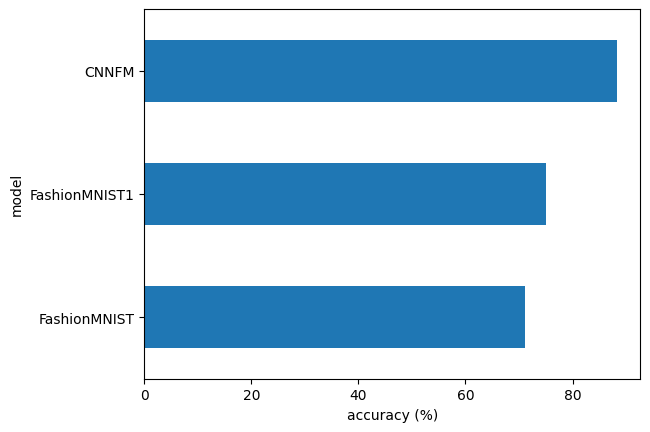

In [28]:
# Visualize our model result
model_comparison.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

In [29]:
def make_predictions(model: nn.Module,
                     data = list):
  pred_probs= []
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
      pred_probs.append(pred_prob)

  return torch.stack(pred_probs)

In [30]:
import random
random.seed(42)

test_sample = []
test_label = []

for sample, label in random.sample(list(test_data), k=9):
  test_sample.append(sample)
  test_label.append(label)

print(f"test_sample: {test_sample[0].shape}")
print(f"test_label: {test_label[0]}({class_names[test_label[0]]})")

test_sample: torch.Size([1, 28, 28])
test_label: 5(Sandal)


In [31]:
pred_probs = make_predictions(model= model_FMNIST_CNN, data = test_sample)
pred_probs[:2]

tensor([[4.2793e-08, 1.2068e-09, 4.4756e-09, 1.8620e-08, 5.9041e-10, 9.9997e-01,
         3.8214e-08, 1.3844e-05, 3.0237e-06, 1.7553e-05],
        [6.2735e-02, 4.1885e-01, 1.0143e-03, 1.4868e-01, 6.7687e-02, 2.5854e-05,
         3.0053e-01, 2.7937e-04, 1.1591e-04, 7.9455e-05]])

In [32]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_FMNIST_CNN,
                             data=test_sample)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[4.2793e-08, 1.2068e-09, 4.4756e-09, 1.8620e-08, 5.9041e-10, 9.9997e-01,
         3.8214e-08, 1.3844e-05, 3.0237e-06, 1.7553e-05],
        [6.2735e-02, 4.1885e-01, 1.0143e-03, 1.4868e-01, 6.7687e-02, 2.5854e-05,
         3.0053e-01, 2.7937e-04, 1.1591e-04, 7.9455e-05]])

In [33]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes


tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [34]:
test_label, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

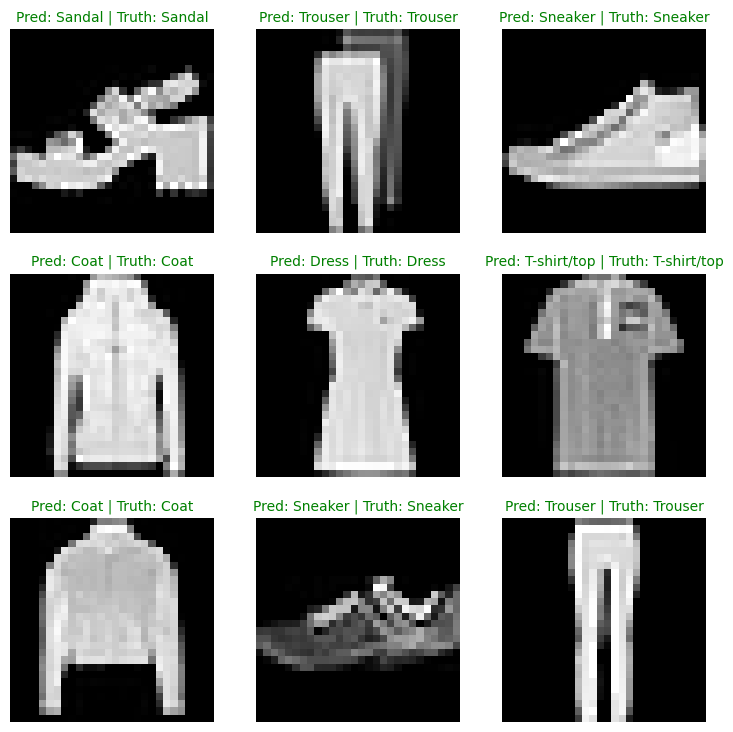

In [35]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols =3
for i, sample in enumerate(test_sample):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap = 'gray')
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_label[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  if pred_label==truth_label:
    plt.title(title_text, fontsize=10, color="g")
  else:
    plt.title(title_text, fontsize=10, color="r")
  plt.axis("off")

In [36]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_FMNIST_CNN.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dload, desc="Making predictions"):
    # Do the forward pass
    y_logit = model_FMNIST_CNN(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred)
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [37]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 26.8 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [38]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


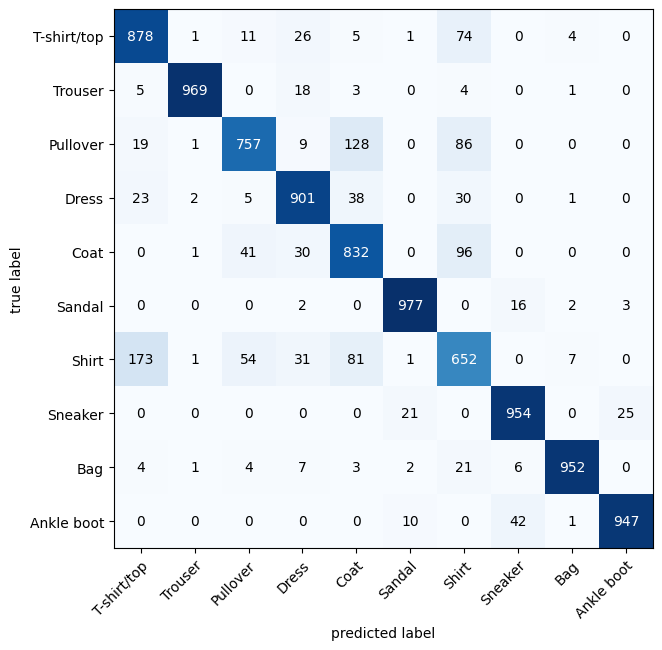

In [39]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [40]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_FMNIST_CNN.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [42]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = CNNFM(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2

In [43]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dload,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'CNNFM',
 'model_loss': 0.322807252407074,
 'model_acc': 88.20886581469648}

In [44]:
model2

{'model_name': 'CNNFM',
 'model_loss': 0.322807252407074,
 'model_acc': 88.20886581469648}

In [45]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model2["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)